In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentencepiece
!pip install nlpaug
!pip install transformers
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00


In [3]:
!pip install torch
!pip install transformers

import nlpaug.augmenter.word as naw
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import XLNetForSequenceClassification, XLNetTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from transformers import AdamW

In [4]:


# Step 1: Prepare the data
data = pd.read_csv('/content/drive/MyDrive/NLP Final Project/Unbalanced_data.csv.csv')
data = data.dropna()
X = data['description']
y = data['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fine-tune the XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(data['label'].unique()))
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


# Tokenize the input data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')
# Convert the input data to tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                             torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

# Define batch size and create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 20


train_accuracy_list = []
train_loss_list = []
test_loss_list = []
test_accuracy_list  = []
epoch_list = []

tokenizer.save_pretrained('/content/drive/MyDrive/NLP Final Project/XLNET_TOKENIZER')

# Create the directory for model weights if it does not exist
model_directory = '/content/drive/MyDrive/NLP Final Project/XLNET_WEIGHTS'
os.makedirs(model_directory, exist_ok=True)


for epoch in range(num_epochs):
    epoch_list.append(epoch+1)
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()


    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
    # After training loop
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0



    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, predicted_labels = torch.max(logits, 1)
            test_correct += (predicted_labels == labels).sum().item()
            test_total += labels.size(0)

            test_loss += loss.item()


    test_accuracy = test_correct / test_total
    test_loss = test_loss / len(test_loader)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

    # Save the model weights and optimizer state dictionary
    model_path = f'/content/drive/MyDrive/NLP Final Project/XLNET_WEIGHTS/model_epoch_{epoch + 1}.pt'
    torch.save(model.state_dict(), model_path)



Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-4-fda510389591>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
<ipython-input-4-fda510389591>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
<ipython-input-4-fda510389591>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
<ipython-input-4-fda510389591>:25: UserWarning: To copy construct from a tensor, it is recommended to use 

Epoch 1/20 - Train Loss: 2.8512 - Train Accuracy: 0.2634
Epoch 1/20 - Test Loss: 2.3858 - Test Accuracy: 0.3483
Epoch 2/20 - Train Loss: 2.3360 - Train Accuracy: 0.3306
Epoch 2/20 - Test Loss: 2.0748 - Test Accuracy: 0.3283
Epoch 3/20 - Train Loss: 1.9967 - Train Accuracy: 0.3685
Epoch 3/20 - Test Loss: 1.8993 - Test Accuracy: 0.3204
Epoch 4/20 - Train Loss: 1.7722 - Train Accuracy: 0.3848
Epoch 4/20 - Test Loss: 1.8664 - Test Accuracy: 0.3174
Epoch 5/20 - Train Loss: 1.6211 - Train Accuracy: 0.4065
Epoch 5/20 - Test Loss: 1.9091 - Test Accuracy: 0.2754
Epoch 6/20 - Train Loss: 1.4927 - Train Accuracy: 0.4210
Epoch 6/20 - Test Loss: 1.8894 - Test Accuracy: 0.2405
Epoch 7/20 - Train Loss: 1.4058 - Train Accuracy: 0.4380
Epoch 7/20 - Test Loss: 1.9540 - Test Accuracy: 0.2216
Epoch 8/20 - Train Loss: 1.3227 - Train Accuracy: 0.4439
Epoch 8/20 - Test Loss: 1.9685 - Test Accuracy: 0.2026
Epoch 9/20 - Train Loss: 1.2512 - Train Accuracy: 0.4417
Epoch 9/20 - Test Loss: 2.0314 - Test Accuracy:

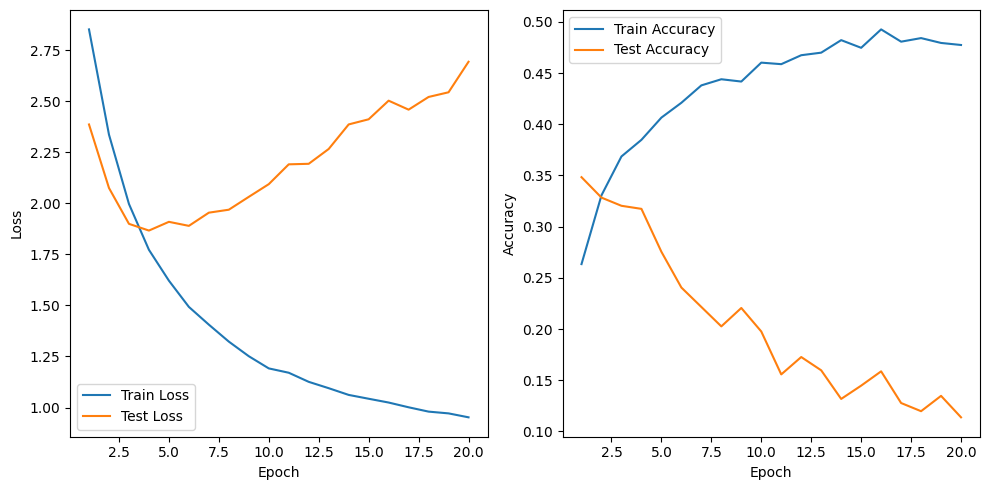

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save the plots to a specific directory
plots_dir = '/content/drive/MyDrive/NLP Final Project/PLOTS'
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, 'xlnet_loss_and_accuracy_curves.png'))
plt.show()